# Анализ пользовательской активации

## **Цель блокнота**
- Понять, какие ранние действия и характеристики отличают пользователей, которые доходят до второй успешной транзакции


*В рамках анализа пользователь считается **активированным**,
если он совершил не менее двух успешных (delivered) заказов.
Данное определение отражает факт повторного использования продукта.*


##**1. Подготовка данных**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
customers = pd.read_csv(
    "olist_customers_dataset.csv")

orders = pd.read_csv(
    "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ],
    dtype={
        "order_id": "string",
        "customer_id": "string",
        "order_status": "string"
    }
)

payments = pd.read_csv(
    "olist_order_payments_dataset.csv")

items = pd.read_csv(
    "olist_order_items_dataset.csv",
    parse_dates=["shipping_limit_date"]
)

customers_unique = customers[["customer_id", "customer_unique_id"]]
orders_users = orders.merge(
    customers_unique,
    on="customer_id",
    how="left")

delivered_orders = orders_users[
    orders_users["order_status"] == "delivered"].copy()

user_orders = (
    delivered_orders.groupby("customer_unique_id").agg(
        orders_cnt=("order_id", "nunique"),
        first_order_date=("order_purchase_timestamp", "min")).reset_index()
)

In [6]:
activated_users = user_orders.copy()

activated_users["is_activated"] = activated_users["orders_cnt"] >= 2

# проверка
activated_users["is_activated"].value_counts(normalize=True)


,proportion
is_activated,
False,0.969997
True,0.030003


## **2. Глубина первой транзакции**
Посмотрим на количество товаров в первом заказе

In [7]:
first_orders = delivered_orders.sort_values("order_purchase_timestamp").groupby("customer_unique_id").first().reset_index()[["customer_unique_id", "order_id"]]

first_order_items = first_orders.merge(items, on="order_id", how="left").groupby("customer_unique_id")["order_item_id"].count().reset_index(name="items_in_first_order")

activated_users = activated_users.merge(first_order_items, on="customer_unique_id", how="left")

In [8]:
activated_users.groupby("is_activated")["items_in_first_order"].mean()


,items_in_first_order
is_activated,
False,1.137228
True,1.219921


<Figure size 640x480 with 0 Axes>

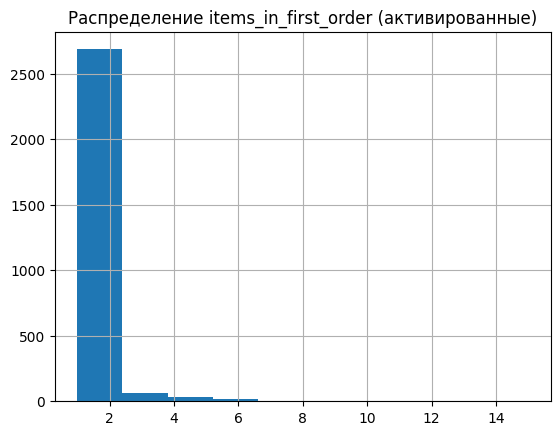

<Figure size 640x480 with 0 Axes>

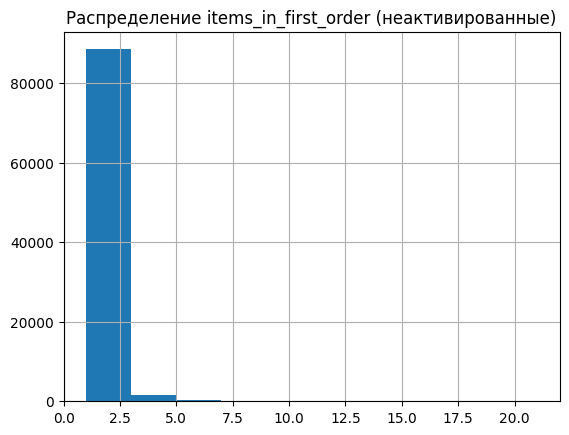

In [9]:
plt.figure()
activated_users[activated_users["is_activated"]].hist(
    column="items_in_first_order",
    bins=10
)
plt.title("Распределение items_in_first_order (активированные)")
plt.show()

plt.figure()
activated_users[~activated_users["is_activated"]].hist(
    column="items_in_first_order",
    bins=10
)
plt.title("Распределение items_in_first_order (неактивированные)")
plt.show()


Медианные значения количества товаров в первом заказе совпадают для активированных и неактивированных пользователей (медиана = 1), что объясняется высокой долей заказов с одним товаром.
Однако средние значения и хвосты в распределениях показывают, что активированные пользователи чаще совершают более "глубокие первые покупки".

<Figure size 640x480 with 0 Axes>

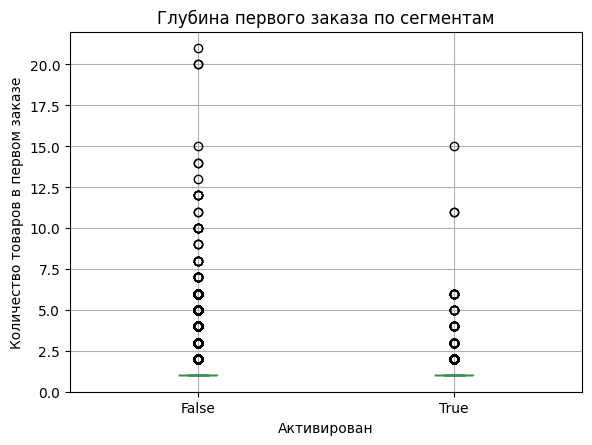

In [17]:
plt.figure()
activated_users.boxplot(column="items_in_first_order", by="is_activated")
plt.title("Глубина первого заказа по сегментам")
plt.suptitle("")
plt.xlabel("Активирован")
plt.ylabel("Количество товаров в первом заказе")
plt.show()

**Протестируем гипотезу**

**H₀:** Распределение количества товаров в первом заказе одинаково у активированных и неактивированных пользователей

**H₁:** Активированные пользователи совершают более глубокий первый заказ, чем неактивированные

In [10]:
from scipy.stats import mannwhitneyu

a = activated_users.query("is_activated == True")["items_in_first_order"]
b = activated_users.query("is_activated == False")["items_in_first_order"]

stat, p_value = mannwhitneyu(a, b, alternative="greater")
print('p-value =', np.round(p_value, 2))

p-value = 0.0


Полученное p-value меньше всех разумных уровней значимости, что позволяет нам отвергнуть нулевую гипотезу и говорить о статистически значимом различии в глубине первого заказа.

При этом эффект наблюдается в правом хвосте распределения: активированные пользователи чаще совершают более глубокие первые покупки, что может указывать на то, что насыщенность первого опыта может повышать вероятность повторного использования

##**2. Способ оплаты**

In [11]:
first_order_payments = first_orders.merge(payments, on="order_id", how="left").groupby(["customer_unique_id","payment_type"]).size().reset_index(name="cnt")

payment_activation = first_order_payments.merge(
    activated_users[["customer_unique_id","is_activated"]],
    on="customer_unique_id", how="left").groupby("payment_type")["is_activated"].mean().sort_values(ascending=False)

payment_activation


,is_activated
payment_type,
voucher,0.036857
credit_card,0.029965
boleto,0.029852
debit_card,0.022901


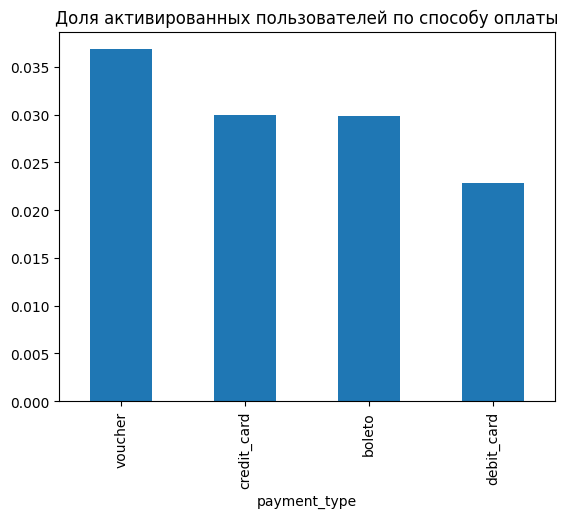

In [12]:
payment_activation.plot(kind="bar", title="Доля активированных пользователей по способу оплаты");

**Протестируем гипотезу**

H₀: вероятность активации одинакова для всех типов оплаты

H₁: вероятность активации различается по типу оплаты

In [13]:
f = first_order_payments.merge(
    activated_users[["customer_unique_id","is_activated"]],
    on="customer_unique_id", how="left")

In [18]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(
    f["payment_type"],
    f["is_activated"])

chi2, p, dof, expected = chi2_contingency(contingency)
print('p-value:', np.round(p, 3))


p-value: 0.044


p-value < 0.05, можно говорить о статистически значимых различиях по способам оплаты, однако требуется дополнительный анализ причин. Возможно, стоит оптимизировать UX

## Выводы actuvation-анализа

1. Активированные пользователи чаще совершают глубокую первую транзакцию
2. Некоторые способы оплаты ассоциированы с более высокой вероятностью активации